In [1]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_dir = './models/'
model_file = model_dir + 'unetpp.h5'

Keras = 2.15.0
Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip -o drive/MyDrive/dataset_19.zip

! pwd

Archive:  drive/MyDrive/dataset_19.zip
   creating: dataset_19/glioma/
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflating: data

# Load the data

In [21]:
# Data Directories
dir = "dataset_19/"


## Data Distribution

In [ ]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

meningioma    120
pituitary     120
glioma        120
notumor       120
dtype: int64

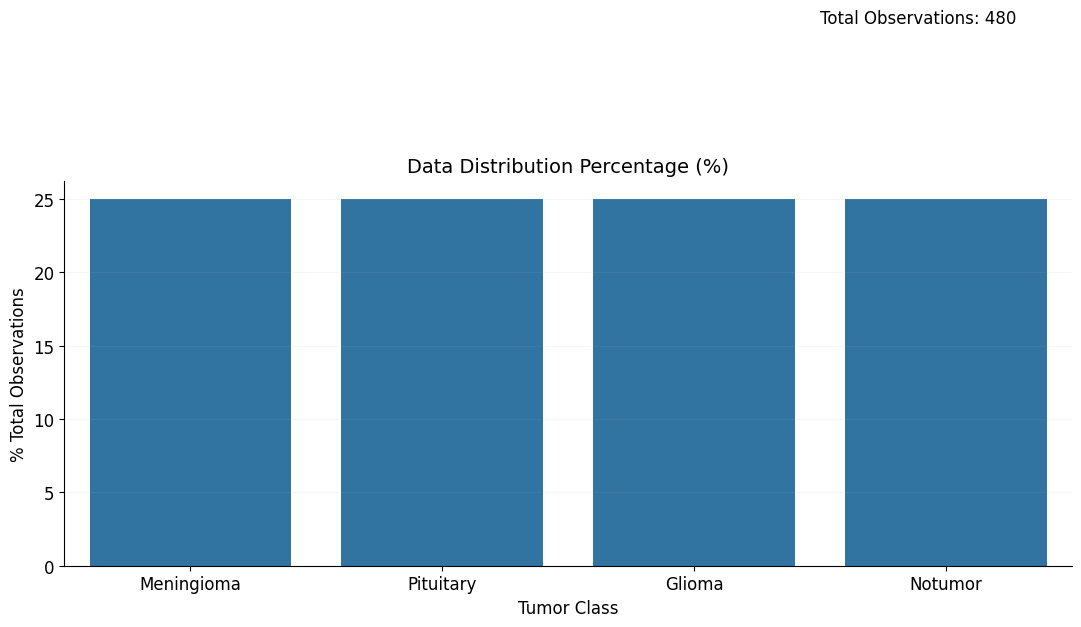

In [ ]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess Data


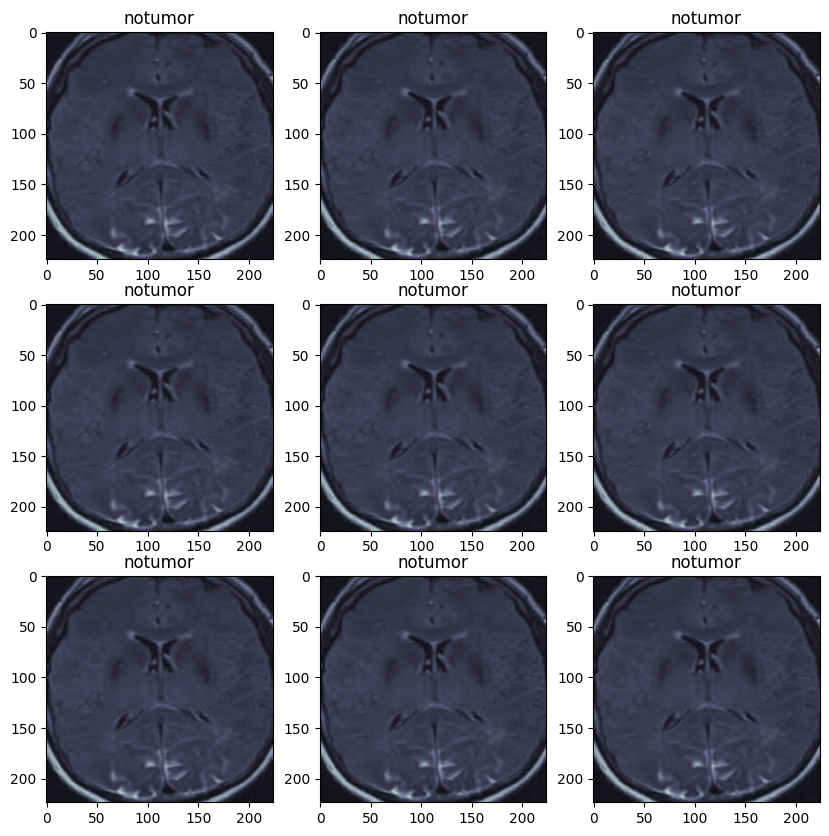

In [5]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

  # Find extreme points on the image and crop the rectangular out

  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (3, 3), 0)

  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  # find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  ADD_PIXELS = 0
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

  return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            processed_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
            processed_img = cv2.bilateralFilter(processed_img, 2, 50, 50)
            processed_img = cv2.applyColorMap(processed_img, cv2.COLORMAP_BONE)
            processed_img = cv2.resize(processed_img, (224, 224))
            cv2.imwrite(img_path, processed_img)


# Preprocess the images before generating data
preprocess_images(dir)

# Display 9 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for curr_index in os.listdir(dir):
        path = os.path.join(dir, curr_index)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            image = plt.imread(img_path)
            plt.imshow(image)
            plt.title(curr_index)
            break
        break


## Splitting the data

In [11]:
classes = os.listdir(dir)

batch_size = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    shuffle = False,
    subset='validation')


print(test_generator.class_indices)


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Model Training

In [7]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.794525 to fit

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 224, 224, 4)       12641604  
                                                                 
 global_average_pooling2d_2  (None, 4)                 0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
Total params: 12641624 (48.22 MB)
Trainable params: 12577592 (47.98 MB)
Non-trainable params: 64032 (250.12 KB)
_________________________________________________________________


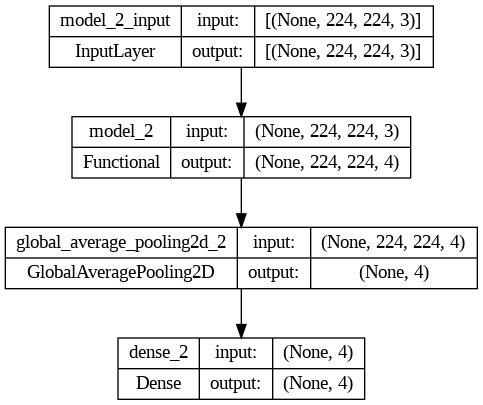

In [14]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
from segmentation_models import Unet
from tensorflow.keras.regularizers import l2

# Model parameters
input_shape = (224, 224, 3)
num_classes = 4
initial_learning_rate = 1e-4

# Define the U-Net++ model
model = Unet('efficientnetb1', input_shape=input_shape, classes=num_classes, activation=None)
tf.keras.utils.plot_model(model, to_file='unetpp_model.png', show_shapes=True, show_layer_names=True)

# Add a GlobalAveragePooling2D layer to collapse spatial dimensions
model = keras.Sequential([
    model,
    keras.layers.GlobalAveragePooling2D()  # Pool across spatial dimensions
])

# Add a Dense layer with softmax activation for final classification
model.add(keras.layers.Dense(num_classes, activation='softmax'))

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()
tf.keras.utils.plot_model(model, to_file='unetpp_model2.png', show_shapes=True, show_layer_names=True)


In [15]:
from keras.callbacks import *

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 1.2954 - accuracy: 0.3770
Epoch 1: val_loss improved from inf to 2.40400, saving model to ./models/unetpp.h5
38/38 [==============================] - 58s 203ms/step - loss: 1.2954 - accuracy: 0.3770 - val_loss: 2.4040 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 0.9815 - accuracy: 0.6337
Epoch 2: val_loss improved from 2.40400 to 1.26136, saving model to ./models/unetpp.h5
38/38 [==============================] - 6s 148ms/step - loss: 0.9815 - accuracy: 0.6337 - val_loss: 1.2614 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 0.8013 - accuracy: 0.7353
Epoch 3: val_loss improved from 1.26136 to 1.13729, saving model to ./models/unetpp.h5
38/38 [==============================] - 6s 147ms/step - loss: 0.8013 - accuracy: 0.7353 - val_loss: 1.1373 - val_accuracy: 0.5222 - lr: 1.0000e-04
Epoch 4/100
3

# Testing the Model

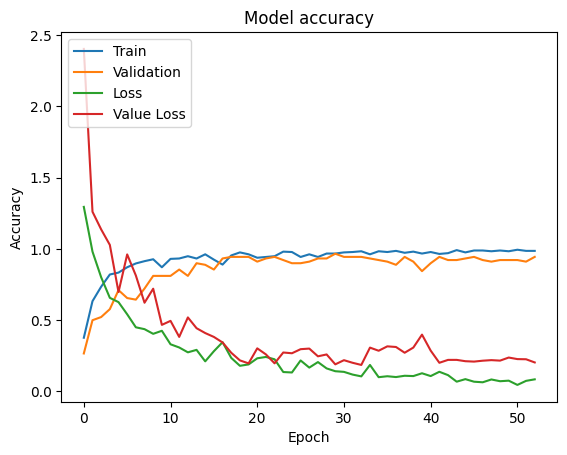

In [16]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

In [17]:
# Validate the model with test data

model = keras.models.load_model(model_file)
model.evaluate(test_generator)


# Predict and Display image using matplotlib
# plt.figure(figsize=(20, 20))
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     for X_batch, Y_batch in test_generator:
#         image = X_batch[0]
#         # Print Class
#         plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

#         plt.imshow(image)
#         break


10/10 [==============================] - 3s 148ms/step - loss: 0.1967 - accuracy: 0.9375


[0.19670744240283966, 0.9375]

# Model Visualisation (Evaluation)

10/10 [==============================] - 2s 21ms/step


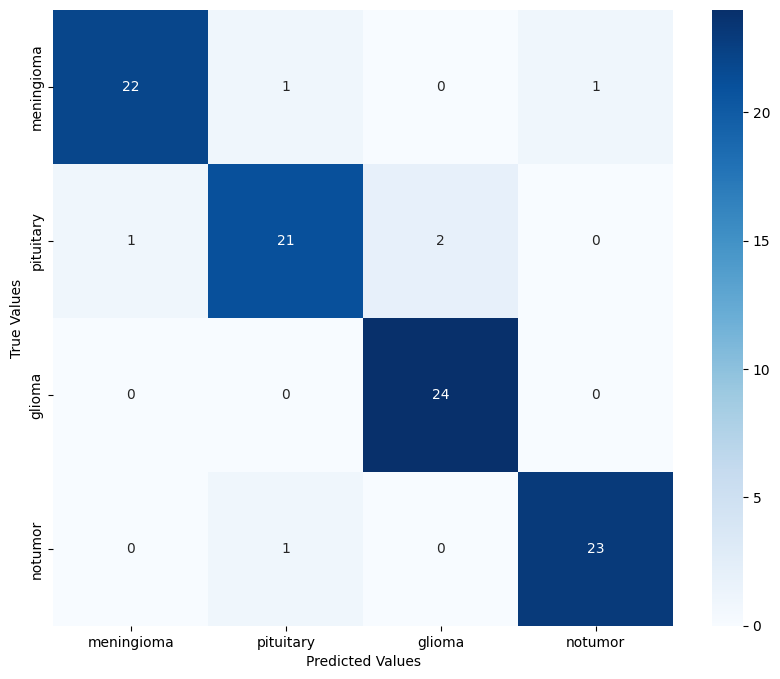

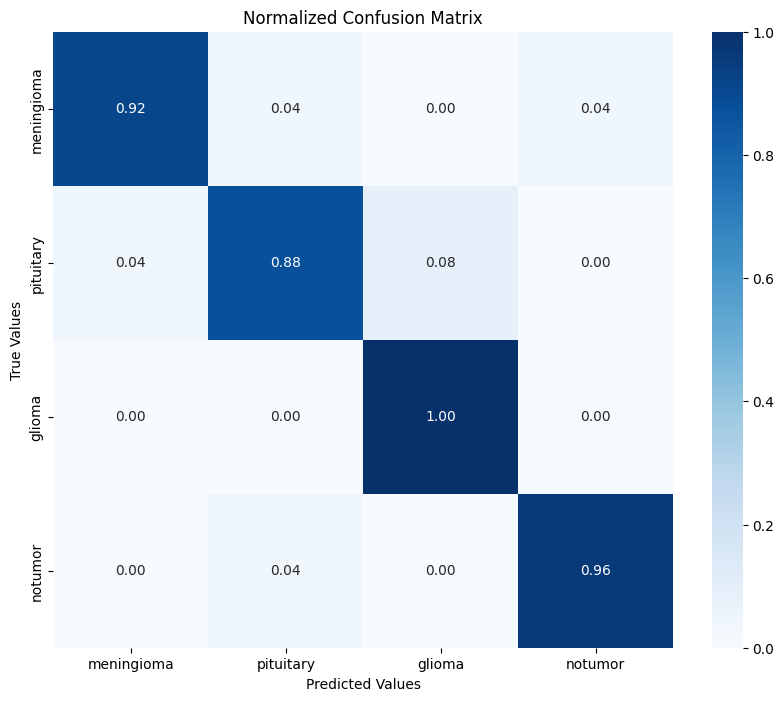

DSC: 0.9370301418439716, Sensitivity: 0.9375, Specificity: 0.9791666666666667, Accuracy: 0.9375


In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

classes = ['meningioma', 'pituitary', 'glioma', 'notumor']

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Predict the output
predictions_prob = model.predict(test_generator)
predictions = np.argmax(predictions_prob, axis=1)

dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")


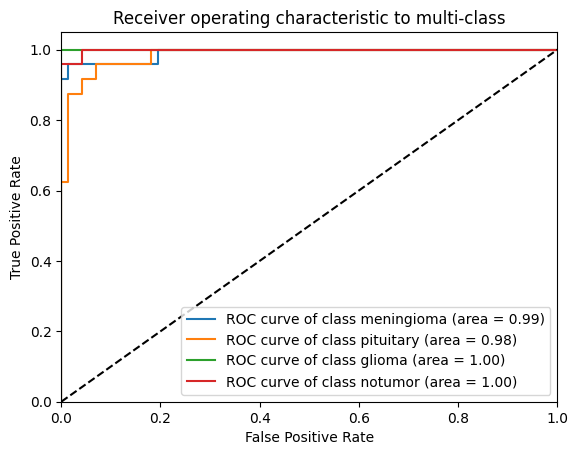

              precision    recall  f1-score   support

  meningioma       0.96      0.92      0.94        24
   pituitary       0.91      0.88      0.89        24
      glioma       0.92      1.00      0.96        24
     notumor       0.96      0.96      0.96        24

   micro avg       0.94      0.94      0.94        96
   macro avg       0.94      0.94      0.94        96
weighted avg       0.94      0.94      0.94        96
 samples avg       0.94      0.94      0.94        96



In [19]:
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
lb = LabelBinarizer()
y_test = lb.fit_transform(test_generator.classes)
y_pred = lb.transform(predictions)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))

# Optimisation

In [ ]:
!pip install optuna tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 13.1 MB/s eta 0:00:00


In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import optuna
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from segmentation_models import Unet
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Model parameters
input_shape = (224, 224, 3)
num_classes = 4
initial_learning_rate = 1e-4

def create_model(model):
    # Define the U-Net++ model
    model = Unet(model, input_shape=input_shape, classes=num_classes, activation=None)

    # Add a GlobalAveragePooling2D layer to collapse spatial dimensions
    model = keras.Sequential([
        model,
        keras.layers.GlobalAveragePooling2D()  # Pool across spatial dimensions
    ])

    # Add a Dense layer with softmax activation for final classification
    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    # Select optimizer
    optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def objective(trial):
    # Suggest Models (Other models other than efficientnet)
    base_model = trial.suggest_categorical('base_model', ['vgg16', 'resnet18', 'inceptionv3', 'mobilenetv2', 'densenet121'])

    # Create model
    model = create_model(base_model)

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.3, min_lr=1e-6, verbose=1)
    checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=35,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Return the best validation loss
    return min(history.history['val_loss'])

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# Print the best trial
best_trial = study.best_trial
print(f"Best trial: {best_trial.value}")
print("Best parameters: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")


[I 2024-06-08 07:30:57,681] A new study created in memory with name: no-name-143a6787-1abf-47aa-97ab-ea451ce02136


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/35
38/38 [==============================] - 26s 256ms/step - loss: 1.2479 - accuracy: 0.5027 - val_loss: 1.1361 - val_accuracy: 0.6111 - lr: 1.0000e-04
Epoch 2/35
38/38 [==============================] - 5s 122ms/step - loss: 1.0934 - accuracy: 0.6203 - val_loss: 2.1893 - val_accuracy: 0.2333 - lr: 1.0000e-04
Epoch 3/35
38/38 [==============================] - 5s 122ms/step - loss: 0.9902 - accuracy: 0.6551 - val_loss: 2.4874 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/35
38/38 [==============================] - 5s 122ms/step - loss: 0.9325 - accuracy: 0.6551 - val_loss: 1.0617 - val_accuracy: 0.5444 - lr: 1.0000e-04
Epoch 5/35
38/38 [==============================] - 5s 123ms/step - loss: 0.8052 - accuracy: 0.7112 - val_loss: 0.9246 - val_accuracy: 0.5889 - lr: 1.0000e-04
Epoch 6/35
38/38 [==============================] - 5s 127ms/step - loss: 0.8802 - accuracy: 0.7059 - val_loss: 0.8703 - val_accuracy: 0.63

[I 2024-06-08 07:34:06,960] Trial 0 finished with value: 0.469392865896225 and parameters: {'base_model': 'vgg16'}. Best is trial 0 with value: 0.469392865896225.


Epoch 1/35
38/38 [==============================] - 38s 202ms/step - loss: 1.2545 - accuracy: 0.4037 - val_loss: 1.3064 - val_accuracy: 0.3444 - lr: 1.0000e-04
Epoch 2/35
38/38 [==============================] - 4s 114ms/step - loss: 0.9793 - accuracy: 0.6604 - val_loss: 1.3408 - val_accuracy: 0.4222 - lr: 1.0000e-04
Epoch 3/35
38/38 [==============================] - 4s 113ms/step - loss: 0.8129 - accuracy: 0.8102 - val_loss: 1.5538 - val_accuracy: 0.4111 - lr: 1.0000e-04
Epoch 4/35
38/38 [==============================] - 4s 115ms/step - loss: 0.6518 - accuracy: 0.8658 - val_loss: 1.1854 - val_accuracy: 0.5778 - lr: 1.0000e-04
Epoch 5/35
38/38 [==============================] - 4s 115ms/step - loss: 0.5665 - accuracy: 0.8957 - val_loss: 1.1837 - val_accuracy: 0.5667 - lr: 1.0000e-04
Epoch 6/35
38/38 [==============================] - 4s 113ms/step - loss: 0.4694 - accuracy: 0.9198 - val_loss: 1.0173 - val_accuracy: 0.6444 - lr: 1.0000e-04
Epoch 7/35
38/38 [===========================

[I 2024-06-08 07:37:16,971] Trial 1 finished with value: 0.41584599018096924 and parameters: {'base_model': 'mobilenetv2'}. Best is trial 1 with value: 0.41584599018096924.


29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/35
38/38 [==============================] - 85s 353ms/step - loss: 1.1730 - accuracy: 0.4385 - val_loss: 1.4873 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 2/35
38/38 [==============================] - 5s 118ms/step - loss: 0.8247 - accuracy: 0.8048 - val_loss: 1.0241 - val_accuracy: 0.6444 - lr: 1.0000e-04
Epoch 3/35
38/38 [==============================] - 5s 118ms/step - loss: 0.6565 - accuracy: 0.8770 - val_loss: 1.0412 - val_accuracy: 0.6222 - lr: 1.0000e-04
Epoch 4/35
38/38 [==============================] - 5s 123ms/step - loss: 0.5418 - accuracy: 0.8984 - val_loss: 0.8066 - val_accuracy: 0.6889 - lr: 1.0000e-04
Epoch 5/35
38/38 [==============================] - 5s 121ms/step - loss: 0.4723 - accuracy: 0.8930 - val_loss: 0.8194 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 6/35
38/38 [==============================] - 5s 118ms/step - loss: 0.4503 - accuracy: 0.8984 - val_loss: 0.7051 - val_accuracy: 0.71

[I 2024-06-08 07:41:26,039] Trial 2 finished with value: 0.3683975338935852 and parameters: {'base_model': 'densenet121'}. Best is trial 2 with value: 0.3683975338935852.


Epoch 1/35
38/38 [==============================] - 33s 140ms/step - loss: 1.1957 - accuracy: 0.4519 - val_loss: 1.5635 - val_accuracy: 0.4222 - lr: 1.0000e-04
Epoch 2/35
38/38 [==============================] - 4s 113ms/step - loss: 0.8267 - accuracy: 0.6979 - val_loss: 1.5192 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 3/35
38/38 [==============================] - 4s 117ms/step - loss: 0.7468 - accuracy: 0.7273 - val_loss: 1.4432 - val_accuracy: 0.5111 - lr: 1.0000e-04
Epoch 4/35
38/38 [==============================] - 4s 115ms/step - loss: 0.6681 - accuracy: 0.7701 - val_loss: 3.0160 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 5/35
38/38 [==============================] - 4s 112ms/step - loss: 0.6152 - accuracy: 0.7674 - val_loss: 3.0779 - val_accuracy: 0.3667 - lr: 1.0000e-04
Epoch 6/35
38/38 [==============================] - 4s 114ms/step - loss: 0.5390 - accuracy: 0.7727 - val_loss: 1.4322 - val_accuracy: 0.5667 - lr: 1.0000e-04
Epoch 7/35
38/38 [===========================

[I 2024-06-08 07:44:29,789] Trial 3 finished with value: 0.7039403319358826 and parameters: {'base_model': 'mobilenetv2'}. Best is trial 2 with value: 0.3683975338935852.


Epoch 1/35
38/38 [==============================] - 14s 134ms/step - loss: 1.3049 - accuracy: 0.3904 - val_loss: 2.2623 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 2/35
38/38 [==============================] - 5s 122ms/step - loss: 1.1220 - accuracy: 0.5348 - val_loss: 1.1507 - val_accuracy: 0.4444 - lr: 1.0000e-04
Epoch 3/35
38/38 [==============================] - 5s 124ms/step - loss: 1.0215 - accuracy: 0.5763 - val_loss: 10.0723 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 4/35
38/38 [==============================] - 5s 122ms/step - loss: 1.0006 - accuracy: 0.5561 - val_loss: 7.5805 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 5/35
38/38 [==============================] - 5s 123ms/step - loss: 0.9584 - accuracy: 0.6070 - val_loss: 1.5792 - val_accuracy: 0.3556 - lr: 1.0000e-04
Epoch 6/35
38/38 [==============================] - 5s 123ms/step - loss: 0.8687 - accuracy: 0.6283 - val_loss: 3.0405 - val_accuracy: 0.4333 - lr: 1.0000e-04
Epoch 7/35
38/38 [==========================

[I 2024-06-08 07:47:26,167] Trial 4 finished with value: 0.700380265712738 and parameters: {'base_model': 'vgg16'}. Best is trial 2 with value: 0.3683975338935852.


Best trial: 0.3683975338935852
Best parameters: 
    base_model: densenet121


# K-Folds Validation

In [25]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from segmentation_models import Unet
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Set parameters
dir = 'dataset_19'  # Update this to your dataset directory
batch_size = 10
input_shape = (224, 224, 3)
num_classes = 4
initial_learning_rate = 1e-4
k = 5

# Prepare data generators
datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20
)

# List all images and labels
all_images = []
all_labels = []

for class_index, class_name in enumerate(os.listdir(dir)):
    class_dir = os.path.join(dir, class_name)
    for image_name in os.listdir(class_dir):
        all_images.append(os.path.join(class_dir, image_name))
        all_labels.append(str(class_index))  # Convert class index to string

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Define K-Fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store metrics
fold_accuracies = []
fold_losses = []

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(kf.split(all_images)):
    print(f'Fold {fold + 1}/{k}')

    train_images, val_images = all_images[train_index], all_images[val_index]
    train_labels, val_labels = all_labels[train_index], all_labels[val_index]

    # Create DataFrames for training and validation data
    train_df = pd.DataFrame({'filename': train_images, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_images, 'class': val_labels})

    # Create training and validation data generators
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Define the U-Net++ model
    model = Unet('efficientnetb1', input_shape=input_shape, classes=num_classes, activation=None)

    # Add a GlobalAveragePooling2D layer and Dense layer with softmax activation
    model = keras.Sequential([
        model,
        keras.layers.GlobalAveragePooling2D(),  # Pool across spatial dimensions
        keras.layers.Dense(num_classes, activation='softmax')  # Final classification layer
    ])

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.3, min_lr=1e-6, verbose=1)
    # checkpoint = ModelCheckpoint(f'model_fold_{fold + 1}.h5', monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=35,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[early_stopping, reduce_lr]
    )

    # Store the best validation accuracy and loss for the current fold
    best_val_accuracy = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    fold_accuracies.append(best_val_accuracy)
    fold_losses.append(best_val_loss)

# Calculate mean and standard deviation of accuracies and losses
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_loss = np.mean(fold_losses)
std_loss = np.std(fold_losses)

print(f'Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}')
print(f'Validation Loss: {mean_loss:.4f} ± {std_loss:.4f}')


Fold 1/5
Found 384 validated image filenames belonging to 4 classes.
Found 96 validated image filenames belonging to 4 classes.
Epoch 1/35
38/38 [==============================] - 57s 190ms/step - loss: 1.2399 - accuracy: 0.3984 - val_loss: 1.8823 - val_accuracy: 0.2111 - lr: 1.0000e-04
Epoch 2/35
38/38 [==============================] - 5s 136ms/step - loss: 0.9369 - accuracy: 0.6471 - val_loss: 1.6458 - val_accuracy: 0.3778 - lr: 1.0000e-04
Epoch 3/35
38/38 [==============================] - 5s 135ms/step - loss: 0.7928 - accuracy: 0.7166 - val_loss: 2.7122 - val_accuracy: 0.2111 - lr: 1.0000e-04
Epoch 4/35
38/38 [==============================] - 5s 139ms/step - loss: 0.6554 - accuracy: 0.7727 - val_loss: 2.0891 - val_accuracy: 0.3778 - lr: 1.0000e-04
Epoch 5/35
38/38 [==============================] - 5s 134ms/step - loss: 0.5753 - accuracy: 0.8182 - val_loss: 1.1983 - val_accuracy: 0.5667 - lr: 1.0000e-04
Epoch 6/35
38/38 [==============================] - 5s 139ms/step - loss: 0.

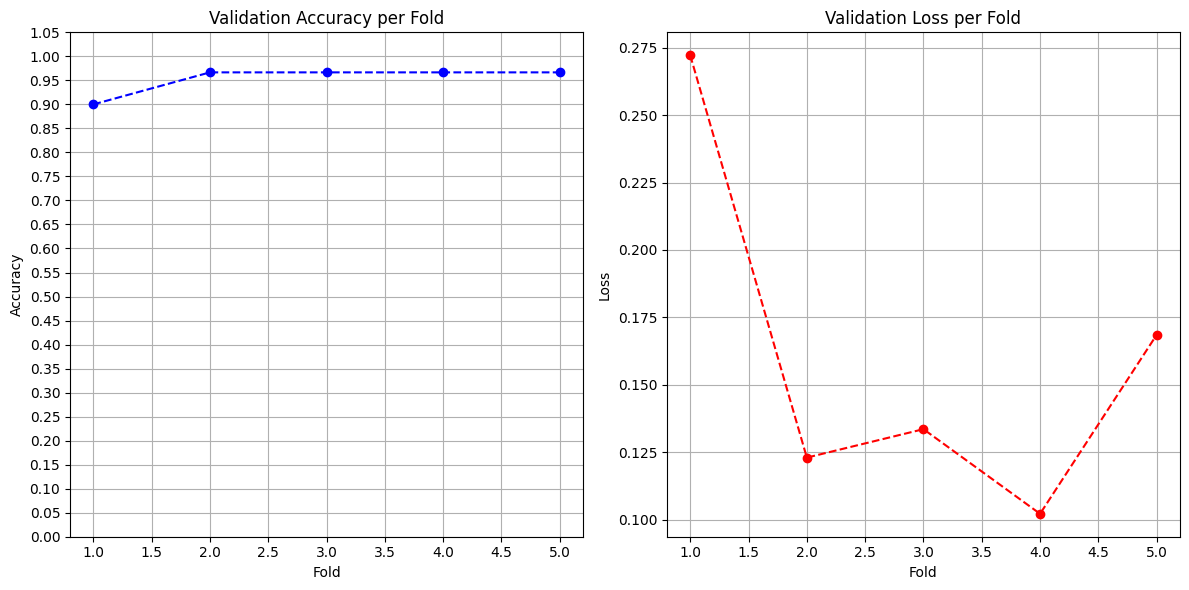

In [29]:
import matplotlib.pyplot as plt

# Plot validation accuracies
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, k + 1), fold_accuracies, marker='o', linestyle='--', color='b')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, k + 1), fold_losses, marker='o', linestyle='--', color='r')
plt.title('Validation Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()